In [1]:
import numpy as np
import gym as gym
from collections import namedtuple, deque
import matplotlib
import matplotlib.pyplot as plt
import time
from IPython import display
import cv2 as cv2
import random
# %matplotlib inline
# matplotlib.get_backend()
# plt.isinteractive()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T


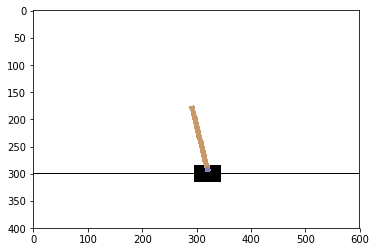

In [2]:
env = gym.make("CartPole-v0")
env.reset()

for i in range(100):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    screen = env.render(mode='rgb_array')
    plt.imshow(screen)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    if done:
        break
        
display.clear_output(wait=True)

env.close()

In [3]:
def process_screen(image):
    img = image[150:330, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

env = gym.make("CartPole-v0")
env.reset()
prev_screen = process_screen(env.render(mode='rgb_array'))

for i in range(1):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    screen = env.render(mode='rgb_array')
    screen = process_screen(screen)
    print(screen.shape)
    plt.imshow(screen, cmap="gray")
    
    if done:
        break
        
env.close()

[2018-01-14 23:12:55,641] Making new env: CartPole-v0


(180, 600)


In [4]:
print(prev_screen.shape)
out = np.stack([screen, prev_screen, np.zeros_like(screen)], axis=2)
print(out.shape)
plt.imshow(out)

(180, 600)
(180, 600, 3)


In [5]:
Transition = namedtuple("Transition", ["s", "a", "s_1", "r"])

a = Transition([0, 1, 2, 3], 0, [4, 5, 6, 7], 0)
print(a)

Transition(s=[0, 1, 2, 3], a=0, s_1=[4, 5, 6, 7], r=0)


In [6]:
deck = deque(maxlen=5)

k = 0
for i in range(6):
    deck.append(k)
    k += 1

print(deck)

deck = deque(range(5), maxlen=3)
print(deck)

deque([1, 2, 3, 4, 5], maxlen=5)
deque([2, 3, 4], maxlen=3)


In [56]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, item):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = item
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        out = random.sample(self.memory, batch_size)
        batched = Transition(*zip(*out))
        s = np.array(list(batched.s))
        a = np.expand_dims(np.array(list(batched.a)), axis=1)
        s_1 = np.array(list(batched.s_1))
        r = np.expand_dims(np.array(list(batched.r)), axis=1)
        return [s, a, s_1, r]

    def __len__(self):
        return len(self.memory)
    
    def __str__(self):
        result = []
        for i in range(self.__len__()):
            result.append(self.memory[i].__str__() + " \n")
        return "".join(result)
        

memory = ReplayMemory(capacity=4)

for i in range(7):
    memory.push(i)


print("len: ", len(memory))
print("Memory:", memory)

memory = ReplayMemory(capacity=10)

for i in range(10):
    a = Transition([0, 1, 2, 3], 0, [4, 5, 6, 7], 0)
    memory.push(a)
    
sample = memory.sample(2)
print(sample)
print(sample[0].shape)
print(sample[1].shape)


len:  4
Memory: 4 
5 
6 
3 

[array([[0, 1, 2, 3],
       [0, 1, 2, 3]]), array([[0],
       [0]]), array([[4, 5, 6, 7],
       [4, 5, 6, 7]]), array([[0],
       [0]])]
(2, 4)
(2, 1)


In [61]:
class DQNLinear(nn.Module):
    def __init__(self, *args):
        super(DQNLinear, self).__init__(*args)
        self.fc1 = nn.Linear(4, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

dqn = DQNLinear()
print(dqn)

# x = np.stack([screen, prev_screen], axis=2)
# x = np.expand_dims(x, axis=0)
# x = np.rollaxis(x, 3, 1)
x = torch.Tensor([1, 1, 1, 1])
x = torch.unsqueeze(x, 0)
x = Variable(x).float()
print(x.data.numpy().shape)
# print(x)
# x = Variable(torch.randn(2, 2, 180, 600))
        
output = dqn(x)
print(output.data.numpy().shape)

# create your optimizer
optimizer = optim.Adam(dqn.parameters(), lr=0.01)
criterion = nn.MSELoss()

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = dqn(x)
loss = criterion(output, Variable(torch.Tensor([0,0])))
loss.backward()
optimizer.step()    # Does the update

DQNLinear (
  (fc1): Linear (4 -> 10)
  (fc2): Linear (10 -> 10)
  (fc3): Linear (10 -> 2)
)
(1, 4)
(1, 2)


# Ok, now we do DQN with the continuous states received rather than pixels

In [9]:
class Epsilon(object):
    def __init__(self, start=1.0, end=0.01, update_increment=0.01):
        self.start = start
        self.end = end
        self.update_increment = update_increment
        self._value = self.start
        self.isTraining = True
    
    def increment(self, count=1):
        self._value = max(self.end, self._value - self.update_increment*count)
        return self
        
    def value(self):
        if not self.isTraining:
            return 0.0
        else:
            return self._value
    
    
eps = Epsilon(start=1.0, end=0.01, update_increment=0.01)
print(eps.value())
print(eps.increment().value())
print(eps.increment().value())
print(eps.increment().value())
print(eps.increment(99).value())
eps.isTraining = False
print(eps.increment().value())
eps.isTraining = True
print(eps.increment().value())

1.0
0.99
0.98
0.97
0.01
0.0
0.01


In [70]:
class DQNLinearLearner(object):
    def __init__(self, env=None):
        self.env = env
        self.epsilon = Epsilon(start=1.0, end=0.01, update_increment=0.01)
        self.gamma = 0.99
        self.train_q_per_step = 10
        self.train_q_batch_size = 10
        
        self.memory = ReplayMemory(capacity=1000)
        self.dqn = DQNLinear()
        self.reset()
        

    def get_action(self, s):
        s = self.state_to_tensor(s)
        actions = self.dqn(s)
        if np.random.rand() > self.epsilon.value():
            action = np.argmax(actions.data.numpy())
#             print(actions.data.numpy())
#             print("not exploring", self.epsilon.value())
        else:
            action = self.env.action_space.sample()
#             print("exploring", action, "epsilon:", self.epsilon.value())
        return action

    def state_to_tensor(self, s):
        x = torch.Tensor(s)
        x = torch.unsqueeze(x, 0)
        x = Variable(x).float()
        return x
    
    def reset(self):
        self.s = env.reset()
    
    def train(self, nb_episodes=1):
        self.epsilon.isTraining = True
        step = 0
        
        for episode in range(nb_episodes):
            self.reset()
            episode_reward = 0
            
            while True:
                action = self.get_action(self.s)
                s_1, r, done, _ = self.env.step(action)
                if done:
                    r = 0
                    
                transition = Transition(self.s, action, s_1, r)
                self.memory.push(transition)
                episode_reward += r
                step += 1
                
                if done:
                    break;
                
                if step % self.train_q_per_step == 0 and step > 0:
                    self.train_q()
                
            self.epsilon.increment() # increment epsilon per episode
            print("Episode reward: ", episode_reward)
    
    def train_q(self):
        print("training q")
        if self.train_q_batch_size < len(self.memory):
            return
        s, a, s_1, r = self.memory.sample(4)
        s = Variable(torch.from_numpy(s)).float()
        a = Variable(torch.from_numpy(a)).float()
        s_1 = Variable(torch.from_numpy(s_1)).float()
        r = Variable(torch.from_numpy(r)).float()
        
        # Q_sa = r + gamma * max(Q_s'a')
        left = self.dqn(s)  #Q_sa
        right = self.dqn(s_1)
        
        print(right)
        print("-----------")
        print(right.max(1))

    def run(self):
        self.reset()
        self.epsilon.isTraining = False
        self.env.render()
        episode_reward = 0
        while True:
            self.env.render()
            action = self.get_action(self.s)
            s_1, r, done, _ = self.env.step(action)
            episode_reward += r

            if done:
                break;
        
        self.env.render(close=True)
        print("Total Reward: ", episode_reward)
    
env = gym.make("CartPole-v0")
learner = DQNLinearLearner(env)

learner.train()


[2018-01-15 00:16:40,877] Making new env: CartPole-v0


training q
Variable containing:
 0.4047  0.2223
 0.4110  0.2460
 0.4167  0.2441
 0.4114  0.2261
[torch.FloatTensor of size 4x2]

-----------
(Variable containing:
 0.4047
 0.4110
 0.4167
 0.4114
[torch.FloatTensor of size 4]
, Variable containing:
 0
 0
 0
 0
[torch.LongTensor of size 4]
)
Episode reward:  15.0


In [ ]:
def process_screen(image):
    img = image[150:330, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

def image2state(s1, s0=None):
    img1 = process_screen(s1)
    if s0 is not None:
        img0 = process_screen(s0)
    else:
        img0 = np.zeros_like(img1)
        
    out = np.stack([img1, img0], axis=2)
    out = np.rollaxis(out, 2, 0)
    out = Variable(torch.from_numpy(out)).float()
    return out


In [ ]:


class DQN(nn.Module):
    def __init__(self, *args):
        super(DQN, self).__init__(*args)
        self.conv1 = nn.Conv2d(2, 10, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(10, 15, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(15, 20, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(20, 25, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(25, 30, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(30 * 6 * 19, 600)
        self.fc2 = nn.Linear(600, 100)
        self.fc3 = nn.Linear(100, 20)
        self.fc4 = nn.Linear(20, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
#         print(x.view(x.size(0), -1))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return x

dqn = DQN()
print(dqn)

x = np.stack([screen, prev_screen], axis=2)
x = np.expand_dims(x, axis=0)
x = np.rollaxis(x, 3, 1)
x = Variable(torch.from_numpy(x)).float()
print(x.data.numpy().shape)
# print(x)
# x = Variable(torch.randn(2, 2, 180, 600))
        
output = dqn(x)
print(output.data.numpy().shape)

# create your optimizer
optimizer = optim.SGD(dqn.parameters(), lr=0.01)
criterion = nn.MSELoss()

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = dqn(x)
loss = criterion(output, Variable(torch.Tensor([0,0])))
loss.backward()
optimizer.step()    # Does the update